# MLFlow 2 

In [2]:
# Importation de librairies standards:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline  

# un nouvel import utile pour la 3D:
from matplotlib import cm
import seaborn as sns
sns.set_style("whitegrid")

# Les instructions suivantes sont TRES utiles pour recharger automatiquement 
# le code modifié dans les librairies externes
%load_ext autoreload
%autoreload 2

# Pour mesurer le temps
import time
import random
import graphviz as gv


# Importation de votre librairie iads:
# La ligne suivante permet de préciser le chemin d'accès à la librairie iads
import sys
sys.path.append('../')   # iads doit être dans le répertoire père du répertoire courant !

# Importation de la librairie iads
import iads as iads

# importation de Classifiers
from iads import Classifiers as classif

# importation de utils
from iads import utils as ut

# importation de evaluation
from iads import evaluation as ev

# importation de Clustering
from iads import Clustering as clust

# commande TRES utile pour recharger automatiquement le code que vous modifiez dans les modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
# Import MLFlow
import mlflow
mlflow.end_run()
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
from sklearn.model_selection import cross_val_score

In [4]:
import mlflow
import os

# Create a directory in your current working directory for tracking
tracking_dir = os.path.join(os.getcwd(), "mlruns_tree")
os.makedirs(tracking_dir, exist_ok=True)

# Set tracking URI with the absolute path
mlflow.set_tracking_uri(f"file://{tracking_dir}")

# Check if tracking URI is set correctly
print(f"Tracking URI: {mlflow.get_tracking_uri()}")

# Set experiment
experiment_name = "tree"
mlflow.set_experiment(experiment_name)

Tracking URI: file:///Users/hoangthuyduongvu/Desktop/sda_mlops/src/models/mlruns_tree


<Experiment: artifact_location='file:///Users/hoangthuyduongvu/Desktop/sda_mlops/src/models/mlruns_tree/961169546191155350', creation_time=1742672922967, experiment_id='961169546191155350', last_update_time=1742672922967, lifecycle_stage='active', name='tree', tags={}>

In [5]:
# Prepare data
# Charger les données
file_path = "../../data/Loan_Data_Preprocessed.csv"
df = pd.read_csv(file_path)

#  Séparer les features et la cible
X = df.drop(columns=['customer_id', 'default'])  # Exclure l'ID client et la cible
y = df['default']

# Définition de variables
X_noms = X.columns

# Conversion en np.ndarray
X = np.array(X)
y = np.array(y)

# Définition de variables
dim = len(X[0])
nb_labels = len(np.unique(y))

# -----
# Définition des données d'apprentissage (on reprend les données data_gauss générées plus haut)
np.random.seed(42)
(train_desc, train_label), (test_desc, test_label) = ut.genere_train_test(X, y,100)

data_train = train_desc
label_train = train_label
data_test = test_desc
label_test = test_label


index = random.sample(range(len(X)),7000)
data_cv, label_cv = X[index], y[index]

## Arbre

In [5]:
# Configure param grid
param_grid = {
    'input_dimension': [len(X[0]), 8, 10, 12],
    'epsilon': [0.0,0.01, 0.1, 0.5],
}

# Initialisation du modèle Perceptron
arbre = classif.ClassifierArbreNumerique(dim)
# GridSearchCV pour optimiser les hyperparamètres
grid_search = GridSearchCV(estimator=arbre, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(data_train, label_train)

# Affichage des meilleurs paramètres
print("Meilleurs hyperparamètres : ", grid_search.best_params_)

# Utiliser le meilleur modèle pour prédire
best_rf = grid_search.best_estimator_
y_pred = np.array(
    [best_rf.predict(data_test[i]) for i in range(len(data_test))]
)

# Calcul des métriques avec le meilleur modèle
accuracy = accuracy_score(test_label, y_pred)
report = classification_report(test_label, y_pred)

# Log des résultats
mlflow.log_param("best_params", grid_search.best_params_)
mlflow.log_metric("accuracy", accuracy)
mlflow.log_text(report, "classification_report_optimized.txt")

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV] END .....................epsilon=0.0, input_dimension=7; total time=   0.1s
[CV] END .....................epsilon=0.0, input_dimension=7; total time=   0.2s
[CV] END .....................epsilon=0.0, input_dimension=8; total time=   0.1s
[CV] END .....................epsilon=0.0, input_dimension=8; total time=   0.2s
[CV] END .....................epsilon=0.0, input_dimension=7; total time=   0.2s
[CV] END .....................epsilon=0.0, input_dimension=7; total time=   0.1s
[CV] END .....................epsilon=0.0, input_dimension=7; total time=   0.2s
[CV] END .....................epsilon=0.0, input_dimension=8; total time=   0.1s
[CV] END ....................epsilon=0.0, input_dimension=10; total time=   0.1s
[CV] END .....................epsilon=0.0, input_dimension=8; total time=   0.0s
[CV] END .....................epsilon=0.0, input_dimension=8; total time=   0.1s
[CV] END ....................epsilon=0.0, input_

In [6]:
# Creat perceptron on best params
arbre = classif.ClassifierArbreNumerique(epsilon=0.0, input_dimension=7)

Cet arbre possède  54  feuilles.


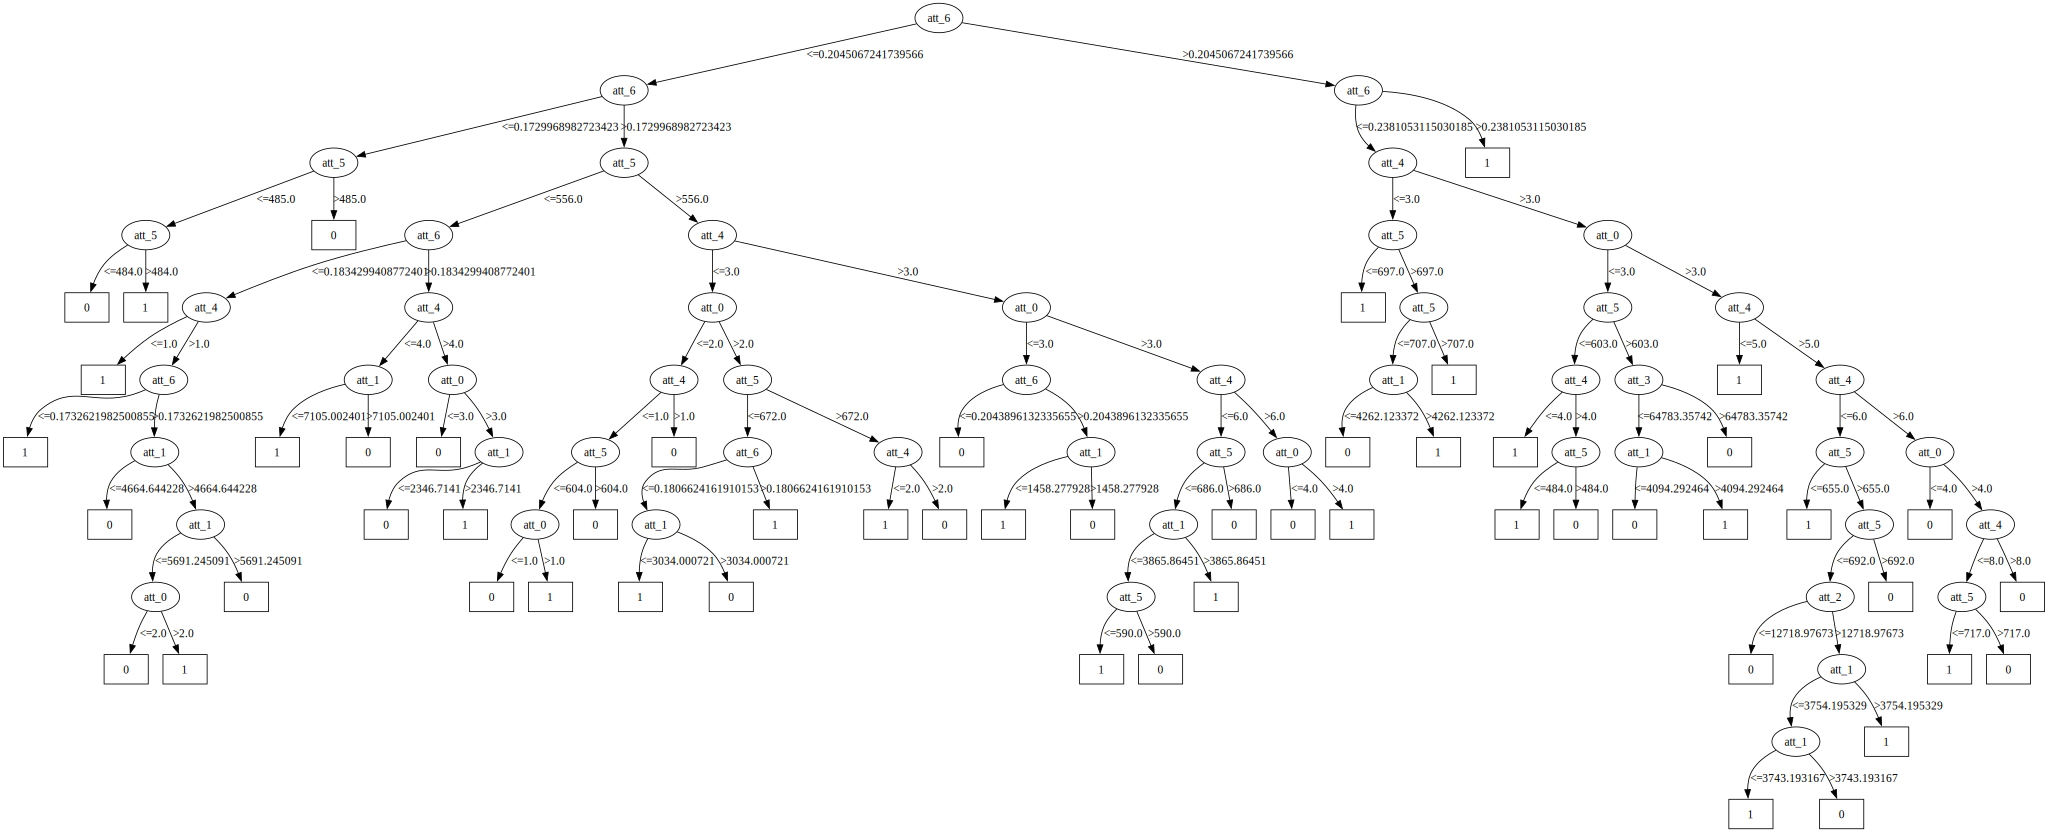

In [8]:
# Construction de l'arbre de décision à partir du dataset Iris
arbre.train(X,y)

# Construction de la représentation graphique (affichage)
graphe_arbre = gv.Digraph(format='png')
arbre.affiche(graphe_arbre)

# Affichage du graphe obtenu:
print("Cet arbre possède ",arbre.number_leaves()," feuilles.")
graphe_arbre


In [7]:
# Wrapper for MLflow
class MyMLflowModel(mlflow.pyfunc.PythonModel):
    def __init__(self, model):
        self.model = model

    def predict(self, context, model_input):
        return self.model.predict(model_input)
    
# Creat perceptron on best params
best_rf = classif.ClassifierPerceptron(dim, learning_rate=0.01, init=True)

mlflow_model = MyMLflowModel(model=best_rf)

mlflow.pyfunc.save_model(path="tree", python_model=mlflow_model)


/Users/hoangthuyduongvu/miniconda3/envs/banking-mlops/lib/python3.13/site-packages/mlflow/pyfunc/utils/data_validation.py:168: UserWarning: Add type hints to the `predict` method to enable data validation and automatic signature inference during model logging. Check https://mlflow.org/docs/latest/model/python_model.html#type-hint-usage-in-pythonmodel for more details.
  color_warning(


In [8]:
# Save tree
graphe_arbre.save("arbre.dot")
graphe_arbre.render("arbre", format='png', cleanup=True)
mlflow.log_artifact("arbre.png")

In [9]:
# mesure du taux de bonne classification
arbre.accuracy(data_test,label_test)
print("Accuracy finale (train): ", arbre.accuracy(data_train,label_train))
print("Accuracy finale (test) : ", arbre.accuracy(data_test,label_test))

Accuracy finale (train):  1.0
Accuracy finale (test) :  1.0


In [10]:
# ################### A COMPLETER 
arbre = classif.ClassifierArbreNumerique(dim, 0.0, X_noms)
tic= time.time()
(res_all, res_moy, res_sd) = ev.validation_croisee(arbre, (data_cv, label_cv), 10)
toc= time.time()
# ################### 
       
print("\nValidation croisée sur les iris avec comme seuil ",0.0)
print("Perf obtenues : ",res_all)
print(f'\nAccuracy moyenne: {res_moy:.3f}\técart type: {res_sd:.3f}')

Itération 0  : taille base app.= 6300  taille base test= 700  Taux de bonne classif: 0.9914285714285714
Itération 1  : taille base app.= 6300  taille base test= 700  Taux de bonne classif: 0.9914285714285714
Itération 2  : taille base app.= 6300  taille base test= 700  Taux de bonne classif: 0.9942857142857143
Itération 3  : taille base app.= 6300  taille base test= 700  Taux de bonne classif: 0.9885714285714285
Itération 4  : taille base app.= 6300  taille base test= 700  Taux de bonne classif: 0.9985714285714286
Itération 5  : taille base app.= 6300  taille base test= 700  Taux de bonne classif: 0.9942857142857143
Itération 6  : taille base app.= 6300  taille base test= 700  Taux de bonne classif: 0.9914285714285714
Itération 7  : taille base app.= 6300  taille base test= 700  Taux de bonne classif: 0.9942857142857143
Itération 8  : taille base app.= 6300  taille base test= 700  Taux de bonne classif: 0.9857142857142858
Itération 9  : taille base app.= 6300  taille base test= 700  Ta

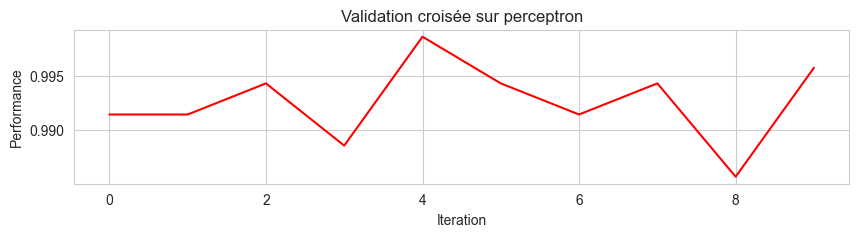

In [11]:
plt.figure(figsize=(10,2))
plt.plot(res_all, c='r')
plt.ylabel('Performance')
plt.xlabel("Iteration")
plt.title("Validation croisée sur perceptron")
plt.savefig("cross_val_perceptron_tree.png")
mlflow.log_artifact("cross_val_perceptron_tree.png")

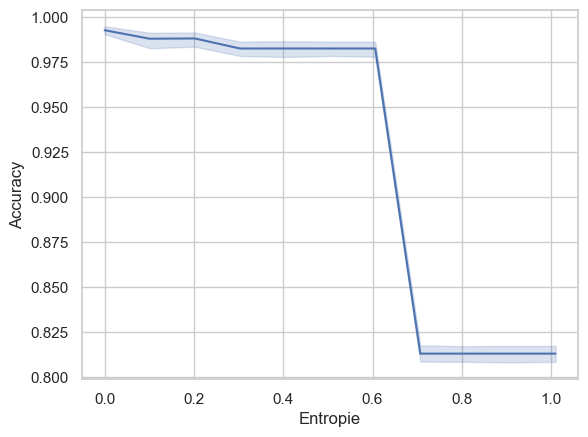

In [13]:
df_res = pd.DataFrame(columns=['Entropie', 'Accuracy'])
array = np.arange(0, 1.111, 0.101)

# ################### A COMPLETER 
entropie = []
acc = []
for i in range(len(array)) : 
  arbre = classif.ClassifierArbreNumerique(dim, array[i], X_noms)
  (res_all, res_moy, res_sd) = ev.validation_croisee(arbre, (data_cv, label_cv), 10, verbose=False)
  for j in range(len(res_all)) : 
    entropie.append(array[i])
    acc.append(res_all[j])

df_res["Entropie"] = entropie
df_res["Accuracy"] = acc
# ################### 
# Le datataframe obtenu :
# Tracé avec lineplot
sns.set_theme(style="whitegrid")
sns.lineplot(x="Entropie", y="Accuracy", data=df_res)
plt.savefig("entropy_acc.png")
mlflow.log_artifact("entropy_acc.png")

### ROC

In [9]:
y_test_pred = np.array([
    arbre.predict(data_test[i]) for i in range(len(data_test))
])

In [11]:
data_test[0].shape

(7,)

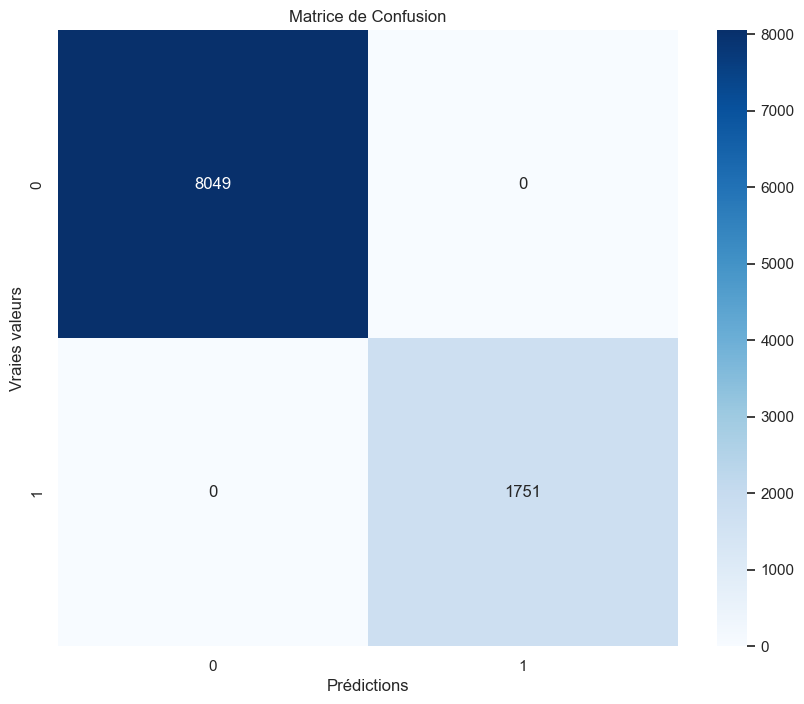

In [21]:
#  Matrice de confusion
cm = confusion_matrix(label_test, y_test_pred)

# Affichage de la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")

# Sauvegarde de l'image de la matrice de confusion
plt.savefig("confusion_matrix_tree.png")

# Enregistrement de l'image dans MLflow
mlflow.log_artifact("confusion_matrix_tree.png")

# Affichage de la matrice
plt.show()


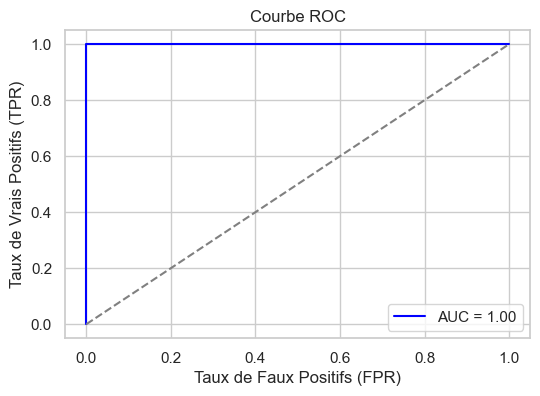

In [22]:
# Prédictions de probabilité pour la classe positive (1)
y_proba = arbre.predict_proba(data_test)[:, 1]  # Probabilités pour la classe 1

# Courbe ROC et AUC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(label_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbe ROC")
plt.legend(loc="lower right")

# # Sauvegarde de la courbe ROC
plt.savefig("roc_curve_tree.png")
mlflow.log_artifact("roc_curve_tree.png")  # Enregistrement dans MLflow


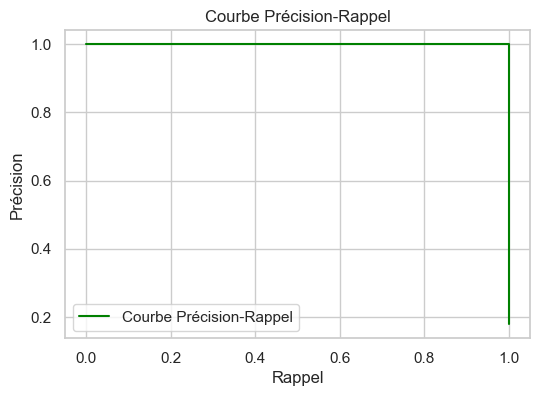

In [23]:
#  Courbe Précision-Rappel
precision, recall, _ = precision_recall_curve(label_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color="green", label="Courbe Précision-Rappel")
plt.xlabel("Rappel")
plt.ylabel("Précision")
plt.title("Courbe Précision-Rappel")
plt.legend(loc="lower left")

plt.savefig("precision_recall_curve_tree.png")
mlflow.log_artifact("precision_recall_curve_tree.png")  
# plt.show()